# Audio File EDA, Image Creation, Pre-processing, FSM

- Converting the the audio files to square Mel-spectrograms, and saving in spectrograms/(BigRoom, DrumAndBass, Techno)
- Applying pre-processing
- FSM CNN with TensorFlow

In [41]:
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.color_palette("Blues", as_cmap=True)

# Standard Packages
import numpy as np
import warnings
import pandas as pd
import os
import shutil
import random
import time
import PIL
pd.set_option('display.max_colwidth', None)
warnings.filterwarnings("ignore")

# ML Libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import keras
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator


#for loading and visualizing audio files
import librosa
import librosa.display
from scipy import signal
from scipy.io import wavfile
import wave

#to play audio
import IPython.display as ipd

### Getting list of genre_names and setting the audio_fpath variable

In [2]:
audio_fpath = "../data/subgenre_dataset/"
genre_names = os.listdir(audio_fpath)
print(genre_names)

['Breaks', 'BigRoom', 'PsyTrance', 'TechHouse', 'ReggaeDub', 'ElectronicaDowntempo', '.DS_Store', 'IndieDanceNuDisco', 'HardcoreHardTechno', 'Trance', 'Minimal', 'ElectroHouse', 'Dance', 'DrumAndBass', 'HipHop', 'GlitchHop', 'House', 'HardDance', 'ProgressiveHouse', 'FutureHouse', 'FunkRAndB', 'Dubstep', 'DeepHouse', 'Techno']


### Getting list of file paths for the 3 selected genres

In [23]:
big_room_file_paths = [audio_fpath + 'BigRoom/' + f for f in os.listdir(audio_fpath + 'BigRoom/') if '.wav' in f]
# big_room_file_paths

In [24]:
dnb_file_paths = [audio_fpath + 'DrumAndBass/' + f for f in os.listdir(audio_fpath + 'DrumAndBass/') if '.wav' in f]
# dnb_file_paths

In [25]:
techno_file_paths = [audio_fpath + 'Techno/' + f for f in os.listdir(audio_fpath + 'Techno/') if '.wav' in f]
# techno_file_paths

### Previewing one song from each genre with ipd

In [14]:
# ipd.Audio(big_room_file_paths[0], autoplay=True)

In [7]:
# ipd.Audio(dnb_file_paths[0], autoplay=True)

In [8]:
# ipd.Audio(techno_file_paths[0], autoplay=True)

## Create spectrogram dataset from the audio files

#### Function that converts to spectrogram, saves it to a file with path: ../spectrograms/'genre_name' and plots it in the notebook

In [9]:
def save_mel_spectrogram(audio_path):

    # Load audio file
    y, sr = librosa.load(audio_path)

    # Compute Mel spectrogram
    n_fft = 4096            # Increase this to increase fft window size --> Increase resolution. More processing time
    hop_length = 512
    n_mels = 128
    S = librosa.feature.melspectrogram(y, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)

    # Convert to decibels
    S_dB = librosa.power_to_db(S, ref=np.max)

    # Display & Save Mel spectrogram
    plt.figure(figsize=(6, 6))
    librosa.display.specshow(S_dB, sr=sr, hop_length=hop_length, cmap='gray_r')
    plt.axis('off')
    plt.tight_layout()
    plt.savefig('../spectrograms/' + audio_path.split('/')[-2] + '/' 
                + audio_path.split('/')[-1].split('.')[0],  
                bbox_inches='tight', pad_inches=0, dpi=1200)
    
    # To view colorbar and axes
    # librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', sr=sr, hop_length=hop_length)
    # plt.colorbar(format='%+2.0f dB')
    # plt.title('Mel-frequency spectrogram')
    # plt.show()

# save_mel_spectrogram(big_room_file_paths[0])

#### Loop that creates the image datasets for BigRoom, DrumAndBass, and Techno

In [10]:
# start_time = time.time()
# for i, (b, d, t) in enumerate(zip(big_room_file_paths, dnb_file_paths, techno_file_paths)):
#     iter_start_time = time.time()
#     save_mel_spectrogram(b)
#     save_mel_spectrogram(d)
#     save_mel_spectrogram(t)
#     print('Iteration ' + str(i) + ': ' + str(time.time() - iter_start_time))
# print(time.time() - start_time)

## Train, Validate, Test Split

In [52]:
# Setting batch size to 1/10 the size of the dataset. Image width and height already loads in as 256x256

batch_size = 32
img_height = 256
img_width = 256
num_channels = 1  # It is grayscale. RGB would be 3


# Set the root directory containing the subdirectories for each class
root_dir = '../spectrograms/'

# Create the train, validation, and test directories
train_dir = root_dir + 'train/'
val_dir = root_dir + 'validate/'
test_dir = root_dir + 'test/'

In [17]:
'''
###### DO NOT RE-RUN WITHOUT DELETING PREVIOUS DIRECTORIES ######

# Set the names of the subdirectories for each class
class_names = ['BigRoom', 'DrumAndBass', 'Techno']

# Set the proportion of images to use for train, validation, and test
train_prop = 0.8
val_prop = 0.1
test_prop = 0.1

os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Loop over each class
for class_name in class_names:
    # Create subdirectories for each class in the train, validation, and test directories
    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

    # Get the list of image filenames for the current class
    image_filenames = os.listdir(os.path.join(root_dir, class_name))

#     # Shuffle the list of image filenames - NOT SHUFFLING FOR NOW - USE SEED IF SO 
#     random.shuffle(image_filenames)

    # Split the image filenames into train, validation, and test sets
    num_images = len(image_filenames)
    num_train = int(num_images * train_prop)
    num_val = int(num_images * val_prop)
    num_test = int(num_images * test_prop)

    train_filenames = image_filenames[:num_train]
    val_filenames = image_filenames[num_train:num_train+num_val]
    test_filenames = image_filenames[num_train+num_val:]

    # Copy the images to the appropriate train, validation, or test directory
    for filename in train_filenames:
        src_path = os.path.join(root_dir, class_name, filename)
        dest_path = os.path.join(train_dir, class_name, filename)
        shutil.copy(src_path, dest_path)

    for filename in val_filenames:
        src_path = os.path.join(root_dir, class_name, filename)
        dest_path = os.path.join(val_dir, class_name, filename)
        shutil.copy(src_path, dest_path)

    for filename in test_filenames:
        src_path = os.path.join(root_dir, class_name, filename)
        dest_path = os.path.join(test_dir, class_name, filename)
        shutil.copy(src_path, dest_path)
'''

"\n###### DO NOT RE-RUN WITHOUT DELETING PREVIOUS DIRECTORIES ######\n\n# Set the names of the subdirectories for each class\nclass_names = ['BigRoom', 'DrumAndBass', 'Techno']\n\n# Set the proportion of images to use for train, validation, and test\ntrain_prop = 0.8\nval_prop = 0.1\ntest_prop = 0.1\n\nos.makedirs(train_dir, exist_ok=True)\nos.makedirs(val_dir, exist_ok=True)\nos.makedirs(test_dir, exist_ok=True)\n\n# Loop over each class\nfor class_name in class_names:\n    # Create subdirectories for each class in the train, validation, and test directories\n    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)\n    os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)\n    os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)\n\n    # Get the list of image filenames for the current class\n    image_filenames = os.listdir(os.path.join(root_dir, class_name))\n\n#     # Shuffle the list of image filenames - NOT SHUFFLING FOR NOW - USE SEED IF SO \n#     r

## Image pre-processing
#### We use Generators because we want to be able to expand this to larger datasets
This means we need to use fit_generator and predict_generator functions during training and testing

In [18]:
# Create data generators for the train, validation, and test sets

# Need to look into the rescale value. This is the scaling used for color images. Should it be different for grayscale?

train_data_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
        directory=train_dir,
        target_size=(img_height, img_width),
        color_mode='grayscale',
        batch_size=batch_size,
        class_mode='categorical')

validation_data_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
        directory=val_dir,
        target_size=(img_height, img_width),
        color_mode='grayscale',
        batch_size=batch_size,
        class_mode='categorical')

test_data_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
        directory=test_dir,
        target_size=(img_height, img_width),
        color_mode='grayscale',
        batch_size=batch_size,
        class_mode='categorical')

Found 240 images belonging to 3 classes.
Found 30 images belonging to 3 classes.
Found 30 images belonging to 3 classes.


## Modeling

Add padding and stride???

In [19]:
# Define the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, num_channels)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(3, activation='softmax')
])

In [20]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [51]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 246016)            0         
                                                                 
 dense (Dense)               (None, 128)               3

In [22]:
start_time = time.time()
history = model.fit_generator(
        train_data_gen,
        steps_per_epoch=train_data_gen.samples // batch_size,
        epochs=5,
        validation_data=validation_data_gen,
        validation_steps=validation_data_gen.samples // batch_size,
        workers=4,
)
print(time.time() - start_time)

Epoch 1/5


2023-04-07 09:22:25.406773: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


8/8 [==============================] - 77s 9s/step - loss: 8.4603 - accuracy: 0.3208 - val_loss: 1.6205 - val_accuracy: 0.3333
Epoch 2/5
8/8 [==============================] - 63s 7s/step - loss: 1.2067 - accuracy: 0.3375 - val_loss: 1.0524 - val_accuracy: 0.5333
Epoch 3/5
8/8 [==============================] - 62s 7s/step - loss: 1.0184 - accuracy: 0.5583 - val_loss: 0.9738 - val_accuracy: 0.4667
Epoch 4/5
8/8 [==============================] - 63s 7s/step - loss: 0.8603 - accuracy: 0.7333 - val_loss: 0.8315 - val_accuracy: 0.5333
Epoch 5/5
8/8 [==============================] - 63s 7s/step - loss: 0.7189 - accuracy: 0.7167 - val_loss: 0.7610 - val_accuracy: 0.6000
342.9243059158325


In [26]:
test_loss, test_acc = model.evaluate_generator(test_data_gen, steps=len(test_data_gen))
print('Test accuracy:', test_acc)

Test accuracy: 0.6666666865348816


In [53]:
# Get the predictions for the test set
test_predictions = model.predict_generator(test_data_gen, steps=test_data_gen.samples // batch_size + 1)
test_predictions = np.argmax(test_predictions, axis=1)

# Get the true labels for the test set
test_labels = test_data_gen.classes

In [56]:
for x in range(len(test_predictions)):
    print(test_predictions[x], test_labels[x])

0 0
1 0
1 0
0 0
0 0
0 0
0 0
2 0
0 0
1 0
2 1
0 1
0 1
1 1
2 1
1 1
1 1
0 1
0 1
0 1
2 2
1 2
2 2
0 2
1 2
0 2
1 2
0 2
1 2
2 2


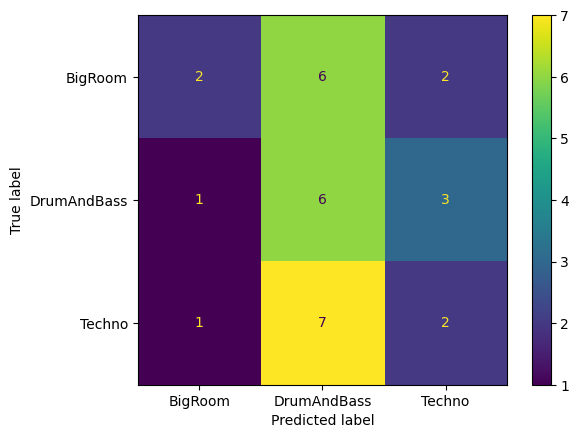

In [38]:
# Create the confusion matrix
confusion_mtx = confusion_matrix(test_labels, test_predictions)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mtx, display_labels=['BigRoom', 'DrumAndBass', 'Techno'])

# Plot the confusion matrix
disp.plot()

### SAVE AND LOAD MODEL

In [40]:
model.save('../models/fsm_cnn_5_epochs_80_10_10_adam_categorical_crossentropy_accuracy.h5')

In [42]:
saved_model = load_model('../models/fsm_cnn_5_epochs_80_10_10_adam_categorical_crossentropy_accuracy.h5')

### SECOND MODEL FOR 10 EPOCHS

In [44]:
start_time = time.time()
model2 = model
model2.fit_generator(
    train_data_gen,
    steps_per_epoch=train_data_gen.samples // batch_size,
    epochs=10,
    validation_data=validation_data_gen,
    validation_steps=validation_data_gen.samples // batch_size,
    workers=8,
)
print(time.time() - start_time)

Epoch 1/10
8/8 [==============================] - 55s 6s/step - loss: 0.5638 - accuracy: 0.7875 - val_loss: 0.5858 - val_accuracy: 0.8000
Epoch 2/10
8/8 [==============================] - 51s 5s/step - loss: 0.4411 - accuracy: 0.8333 - val_loss: 0.6182 - val_accuracy: 0.7333
Epoch 3/10
8/8 [==============================] - 51s 5s/step - loss: 0.3393 - accuracy: 0.8708 - val_loss: 0.6999 - val_accuracy: 0.7333
Epoch 4/10
8/8 [==============================] - 51s 5s/step - loss: 0.2794 - accuracy: 0.9000 - val_loss: 0.6228 - val_accuracy: 0.7667
Epoch 5/10
8/8 [==============================] - 51s 5s/step - loss: 0.2174 - accuracy: 0.9250 - val_loss: 0.4975 - val_accuracy: 0.8667
Epoch 6/10
8/8 [==============================] - 50s 5s/step - loss: 0.1601 - accuracy: 0.9542 - val_loss: 0.6007 - val_accuracy: 0.7667
Epoch 7/10
8/8 [==============================] - 50s 5s/step - loss: 0.0985 - accuracy: 0.9875 - val_loss: 0.5046 - val_accuracy: 0.8667
Epoch 8/10
8/8 [==================

In [50]:
test_loss2, test_acc2 = model2.evaluate_generator(test_data_gen, steps=len(test_data_gen))
print('Test accuracy:', test_acc2)

Test accuracy: 0.6666666865348816


In [47]:
# Get the predictions for the test set
test_predictions2 = model2.predict_generator(test_data_gen, steps=test_data_gen.samples // batch_size + 1)
test_predictions2 = np.argmax(test_predictions2, axis=1)

# Get the true labels for the test set
test_labels2 = test_data_gen.classes

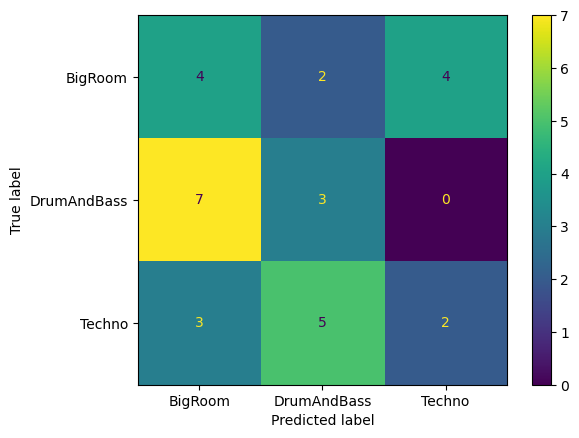

In [57]:
# Create the confusion matrix
confusion_mtx2 = confusion_matrix(test_labels2, test_predictions2)

# Plot the confusion matrix
disp2 = ConfusionMatrixDisplay(confusion_matrix=confusion_mtx2, display_labels=['BigRoom', 'DrumAndBass', 'Techno'])

# Plot the confusion matrix
disp2.plot()

2023-04-07 08:34:46.904852: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 214 of 240
2023-04-07 08:34:47.920747: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


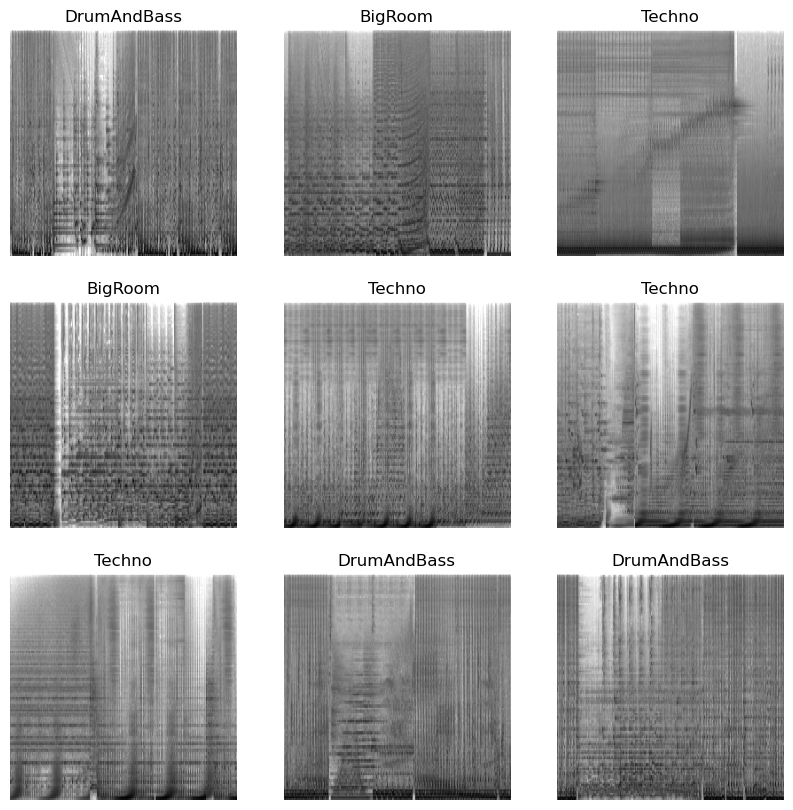

In [127]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(train_ds.class_names[labels[i]])
        plt.axis("off")

In [128]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

2023-04-07 08:35:00.318431: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 211 of 240
2023-04-07 08:35:01.429040: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


(30, 256, 256, 3)
(30,)


In [96]:
PIL.Image.open(big_room_images[0])

# Increasing dataset size

Methodology
- Chopping up a song into pieces
- Maybe different window for Fourier transforms? Do research on this

### Nice Example for Early Stopping

https://stackoverflow.com/questions/71523747/no-val-loss-and-val-accuracy-keys-when-ive-already-had-validation-data-in-model

In [ ]:



# flowers = tf.keras.utils.get_file(
#     'flower_photos',
#     'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
#     untar=True)

# img_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, validation_split=0.2)
# BATCH_SIZE = 32

# train_generator = img_gen.flow_from_directory(flowers, class_mode='sparse', batch_size=BATCH_SIZE, target_size=(300, 300), shuffle=True, subset="training", color_mode="grayscale")
# validation_generator = img_gen.flow_from_directory(flowers, class_mode='sparse', batch_size=BATCH_SIZE, target_size=(300, 300), shuffle=True, subset="validation", color_mode="grayscale")

# model = tf.keras.Sequential([
#     tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu', input_shape=(300, 300, 1)),
#     tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
#     tf.keras.layers.Dropout(0.5),
#     tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
#     tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
#     tf.keras.layers.Dropout(0.5),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(64, activation='relu'),
#     tf.keras.layers.Dropout(0.5),
#     tf.keras.layers.Dense(32, activation='relu'),
#     tf.keras.layers.Dropout(0.5),
#     tf.keras.layers.Dense(5)
# ])

# model.compile(optimizer='adam',
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#               metrics=['accuracy'])

# epochs=10
# early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss',mode='min',verbose=1,patience=7, restore_best_weights=True)

# history = model.fit(train_generator,
#         steps_per_epoch=train_generator.n // BATCH_SIZE,
#         epochs=1,
#         validation_data=validation_generator,
#         validation_steps=validation_generator.n // BATCH_SIZE,
#         callbacks=[early_stopp